In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

BATCH_SIZE = 1
EPOCHS = 10
data_dir = "/content/drive/MyDrive/dataset_auto"

cuda


In [ ]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
    transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

train_dataset = ImageFolder(os.path.join(data_dir, 'train'), transform)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)
print(train_dataset.classes)
print("size of train dataset : ", len(train_dataset))
print(train_dataset[0][0].shape)

test_dataset = ImageFolder(os.path.join(data_dir, 'test'), transform)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2)
print(test_dataset.classes)
print("size of train dataset : ", len(test_dataset))
print(test_dataset[0][0].shape)

['bottle', 'cable', 'capsule']
size of train dataset :  18
torch.Size([3, 224, 224])
['bottle_broken_small', 'bottle_contamination', 'bottle_good', 'cable_bent_wire', 'cable_good', 'cable_missing_wire', 'capsule_good', 'capsule_poke']
size of train dataset :  13
torch.Size([3, 224, 224])


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

tensor(-0.8745) tensor(1.)
torch.Size([1, 3, 224, 224])
torch.float32


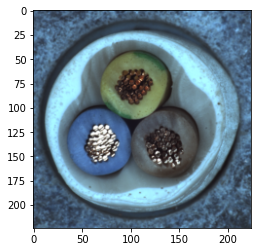

torch.Size([1, 3, 224, 224])


In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

print(images.shape)
print(images.dtype)

imshow(torchvision.utils.make_grid(images))
print(images.shape)

tensor(-0.7569) tensor(1.)


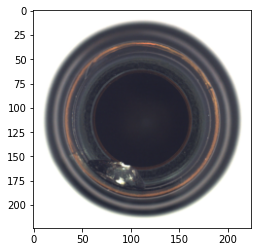

torch.Size([1, 3, 224, 224])


In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

imshow(torchvision.utils.make_grid(images))
print(images.shape)

In [ ]:
# Linear Autoencoder

class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(3*224*224, 128), # (N, 784) -> (N, 128)
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,12),
        nn.ReLU(),
        nn.Linear(12,3) # -> N, 3
    )

    self.decoder = nn.Sequential(
        nn.Linear(3, 12),
        nn.ReLU(),
        nn.Linear(12, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 3*224*224),
        nn.Sigmoid() # To make values 0~1
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# Note : Input [-1, +1] -> use nn.Tanh

In [ ]:
# # CNN Autoencoder

# class Autoencoder(nn.Module):
#   def __init__(self):
#     super().__init__()
#     # N, 3, 224, 224
#     self.encoder = nn.Sequential(
#         nn.Conv2d(3, 16, 4, stride = 2, padding = 1), # N, 16, 112, 112
#         nn.ReLU(),
#         nn.Conv2d(16, 32, 4, stride = 2, padding = 1), # N, 32, 56, 56
#         nn.ReLU(),
#         nn.Conv2d(32, 64, 4, stride = 2, padding = 1), # N, 64, 28, 28
#         nn.ReLU(),
#         nn.Conv2d(64, 128, 4, stride = 2, padding = 1), # N, 128, 14, 14
#         nn.ReLU(),
#         nn.Conv2d(128, 256, 14) # N, 256, 1, 1
#     )

#     self.decoder = nn.Sequential(
#         nn.ConvTranspose2d(256, 128, 14),
#         nn.ReLU(),
#         nn.ConvTranspose2d(128, 64, 4, stride = 2, padding = 1, output_padding = 1),
#         nn.ReLU(),
#         nn.ConvTranspose2d(64, 32, 4, stride = 2, padding = 1, output_padding = 1),
#         nn.ReLU(),
#         nn.ConvTranspose2d(32, 16, 4, stride = 2, padding = 1, output_padding = 1),
#         nn.ReLU(),
#         nn.ConvTranspose2d(16, 3, 4, stride = 2, padding = 1, output_padding = 1),
#         nn.Sigmoid()
#     )

#   def forward(self, x):
#     encoded = self.encoder(x)
#     decoded = self.decoder(encoded)
#     return decoded

In [ ]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
output = []
loss_list = []

for epoch in range(EPOCHS):
  for (img, _) in train_loader:
    img = img.reshape(-1, 224*224*3)
    recon = model(img)
    loss = criterion(recon, img)
    loss_list.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
  output.append((epoch, img, recon))

Epoch:1, Loss:0.2807
Epoch:2, Loss:0.2733
Epoch:3, Loss:0.5991
Epoch:4, Loss:0.5599
Epoch:5, Loss:0.4762
Epoch:6, Loss:0.1838
Epoch:7, Loss:0.1654
Epoch:8, Loss:0.2076
Epoch:9, Loss:0.1988
Epoch:10, Loss:0.1404


torch.Size([3, 224, 224])
torch.float32


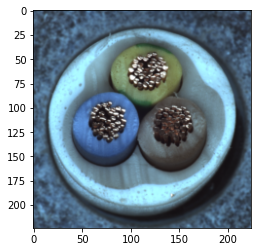

In [ ]:
# output[0][1] ==> img 원본
# output[0][2] ==> reconstructed 사진

img = output[3][1]
img = img.reshape(3, 224,224)
print(img.shape)

print(img.dtype)
# img = img.reshape(3,224,224)
imshow(img)

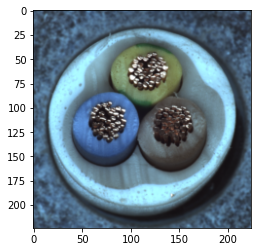

In [ ]:
imshow(torchvision.utils.make_grid(img))

torch.Size([3, 224, 224])
torch.float32


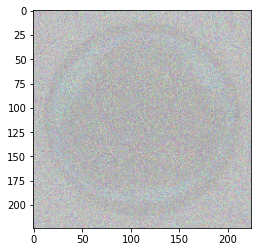

In [ ]:
rec = output[3][2].detach()
rec = rec.reshape(3,224,224)
print(rec.shape)
print(rec.dtype)
imshow(rec)

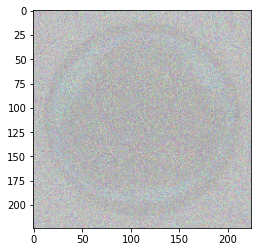

In [ ]:
imshow(torchvision.utils.make_grid(rec))

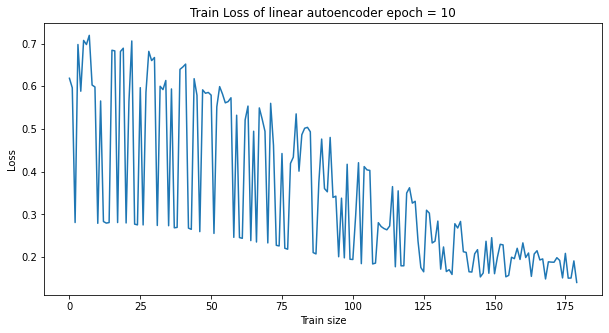

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(loss_list)
plt.xlabel('Train size')
plt.ylabel('Loss')
plt.title('Train Loss of linear autoencoder epoch = 10')
plt.legend
plt.show()